In [29]:
import mlflow
import mlflow.pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

cuda_available = torch.cuda.is_available()

In [8]:
import matplotlib
import torchvision

In [12]:
(matplotlib.__version__)

'3.0.2'

## Splitting the data into training and validation sets

In [3]:
#Converts the images to tensors after normalizing them
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = CIFAR10(root='/data', download=True, train=True, transform=transform)
test_data = CIFAR10(root='/data', download=True, train=False, transform=transform)

In [4]:
#Helper function to get the training and validation indices
def split_indices(n, val_pct):
    n_val = int(n * val_pct)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

train_idxs, validation_idxs = split_indices(len(train_data), 0.3)
print('Training set size: {} \tValidation set size: {}'.format(len(train_idxs), len(validation_idxs)))

Training set size: 35000 	Validation set size: 15000


In [5]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_idxs)
train_loader = DataLoader(train_data,
                         batch_size,
                         sampler = train_sampler)

val_sampler = SubsetRandomSampler(validation_idxs)
val_loader = DataLoader(train_data, 
                       batch_size,
                       sampler = val_sampler)

In [6]:
def imshow(img):
    #Unnormalize
    img = img/2+0.5
    
    #Convert from tensor image
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [7]:
classes = train_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Visualizing the image

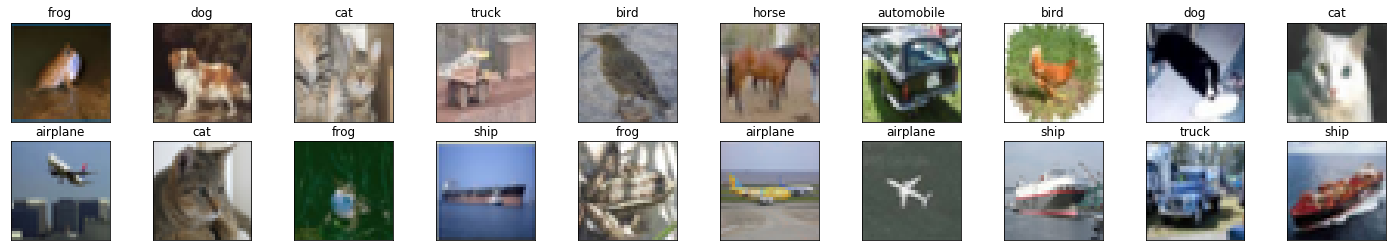

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize = (25, 4))

#Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model

I have implemented the ResNet-18 architecture. This architecture consisists of one convolution layer followed by four residual blocks, each with two convolution layers and a shortcut block, which is used for downsampling the inputs. 

### Residual block
- 1. **Convolution Layer 1**
    - Input and output channels are the same as they are passed when calling this block, as well as the stride. Padding is set to 1. This layer downsamples the images if the input and output size are different and sends it to the next layer. If the input and output size are the same, then no downsampling is done. 
- 2. **Convolution Layer 2**
    - In this layer, the input channels are equal to the output channels. This means there is no downsampling done in this channel. It uses a 3x3 kernel, with stride = 1 and padding = 1.
- 3. **Shortcut Layer**
    - Convolution Layer:  This block is executed when the input channels are not equal to the output channels or when the stride is not equal to 1. This layer takes the original inputs and downsamples them. Then adds them together with the outputs of the previous two convolution layers. Kernel size is 1x1, stride = 1 and padding = 0.

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        '''
        This block takes the input number of channels and directly adds them up 
        to the output of the 2nd convolution layer.
                        INPUT_CHANNELS
                       ______||_______
                       |              |
                    CONV 1            |
                       |        SHORTCUT BLOCK
                    CONV 2            |
                       |_______+______|
                               ||
                               OUT
                       
        '''
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

### ResNet
- **1. Convolution Layer**
    - This layer takes the input images which have dimensions 3x32x32 (3 channels - red, green and blue - and 32x32 pixels in the image). It will convolve 64 filters, each of size 3x3x3. Since padding is set to 1 and stride is also set to 1, the output of this layer will be 64x32x32
- **Block 1**
    - This layer takes the 64x32x32 output from the convolution layer. No downsampling will occur as the input and output dimensions of this block are the same, and the stride is also equal to 1. Therefore, the output size of block 1 will be 64x32x32.
- **Block 2**
    - This layer takes the output from block 2 and downsamples them. Since stride is set to 2, and padding is 1, the output of this layer will be 128x16x16
- **Block 3**
    - This layer will also downsample the outputs from block 2, as the input and output size to this block differ, and stride is also not equal to 1. With stride = 2, padding = 1 and kernel = (3,3), the output of this block will be 256x8x8
- **Block 4**
    - Outputs of block 3 are downsampled to 512x4x4
- **Fully connected layer**
    - Outputs of block 4 are flattened to a 512 size vector and then spewed out as 10 classes. 

In [11]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        
        # Initial input conv
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=(3, 3),
            stride=1, padding=1, bias=False
        )

        self.bn1 = nn.BatchNorm2d(64)
        
        #Input - 64x32x32 Output - 64x32x32
        self.block1 = self._create_block(64, 64, stride=1)
        
        #Input - 64x32x32 Output - 128x16x16
        self.block2 = self._create_block(64, 128, stride=2)
        
        #Input - 128x16x16 Output - 256x8x8
        self.block3 = self._create_block(128, 256, stride=2)
        
        #Input - 256x8x8 Output - 512x4x4
        self.block4 = self._create_block(256, 512, stride=2)
        
        #Input - 512 Output - 10
        self.linear = nn.Linear(512, num_classes)
    
    # A block is just two residual blocks for ResNet18
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [12]:
model = ResNet()
#Move the classifier to the GPU
if cuda_available:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=0.1)

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

## Training the model

In [18]:
for epoch in range(20):
    losses = []
    scheduler.step()
    # Train
    #start = time.time()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        #Set gradients to zero at the start of every batch
        #so that new gradients are not accumulated over the iterations
        optimizer.zero_grad()
        
        #Get outputs
        outputs = model(inputs)                   
        
        #Compute loss
        loss = criterion(outputs, targets)
        
        #Compute gradients
        loss.backward()
        
        #Update parameters
        optimizer.step()
        
        #Append the losses
        losses.append(loss.item())        
      
    # Evaluate
    model.eval()
        
    total = 0
    correct = 0
    
    #Gradients need not be re-calculated for evaluation
    #Hence we tell torch that it does not have to do gradient computation again
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            
        print('Epoch : %d Val Acc : %.3f' % (epoch, 100.*correct/total))
        print('--------------------------------------------------------------')
        
    model.train()

Epoch : 0 Val Acc : 52.000
--------------------------------------------------------------
Epoch : 1 Val Acc : 64.000
--------------------------------------------------------------
Epoch : 2 Val Acc : 71.000
--------------------------------------------------------------
Epoch : 3 Val Acc : 75.000
--------------------------------------------------------------
Epoch : 4 Val Acc : 81.000
--------------------------------------------------------------
Epoch : 5 Val Acc : 81.000
--------------------------------------------------------------
Epoch : 6 Val Acc : 81.000
--------------------------------------------------------------
Epoch : 7 Val Acc : 81.000
--------------------------------------------------------------
Epoch : 8 Val Acc : 81.000
--------------------------------------------------------------
Epoch : 9 Val Acc : 81.000
--------------------------------------------------------------
Epoch : 10 Val Acc : 81.000
--------------------------------------------------------------
Epoch : 1

## Loading the test data

In [21]:
test = CIFAR10(root = '/data', train = False, transform=transform)

In [22]:
testloader = DataLoader(test, batch_size=batch_size,
                        shuffle=False, num_workers=0)

In [23]:
#Containst the different class names
classes = test.classes

### Visualizing the test images

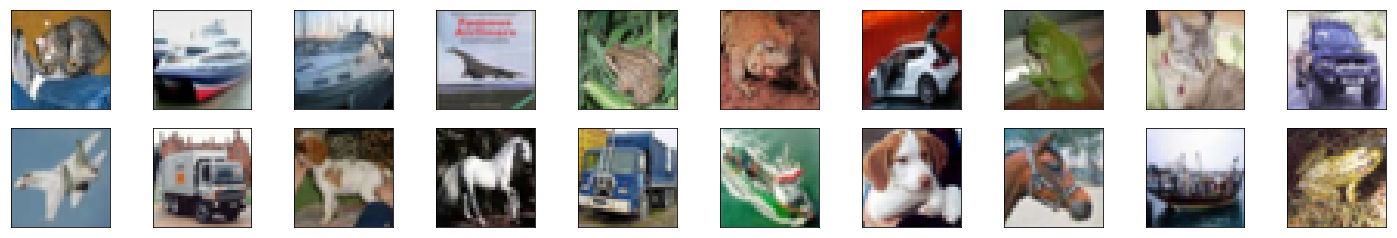

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize = (25, 4))

#Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    imshow(images[idx])

## Evaluating on the test set

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if cuda_available:
                images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


In [26]:
#Display which classes performed particularly well
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = predicted.eq(labels.data).cpu().squeeze()
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 84 %
Accuracy of automobile : 91 %
Accuracy of  bird : 73 %
Accuracy of   cat : 64 %
Accuracy of  deer : 75 %
Accuracy of   dog : 71 %
Accuracy of  frog : 85 %
Accuracy of horse : 82 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %


In [35]:
torch.save(model.state_dict(), 'cifar10-resnet-sgd')

In [28]:
with mlflow.start_run():
    mlflow.log_param('epoch', 10)
    mlflow.log_param('lr', 0.01)
    mlflow.log_param('optimizer', 'SGD')
    mlflow.pytorch.log_model(model, 'model')

E:\Anaconda\lib\site-packages\yaml\constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(key, collections.Hashable):
